<a href="https://colab.research.google.com/github/tanvimathur11/DDA/blob/main/DDA_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/train.csv',low_memory=False)

In [6]:
dataset = dataset.drop(["Amount_invested_monthly", "SSN", "Name", "Month", "Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Type_of_Loan", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix", "Credit_Utilization_Ratio"], axis=1)

In [7]:
dataset.to_csv('final_dataset.csv', index=False)

In [8]:
final_dataset = pd.read_csv('final_dataset.csv')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [9]:
final_dataset.shape

(100000, 15)

Cleaning errors and fixing variables

In [10]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      100000 non-null  object 
 1   Customer_ID             100000 non-null  object 
 2   Occupation              100000 non-null  object 
 3   Annual_Income           100000 non-null  object 
 4   Monthly_Inhand_Salary   84998 non-null   float64
 5   Num_of_Loan             100000 non-null  object 
 6   Delay_from_due_date     100000 non-null  int64  
 7   Num_of_Delayed_Payment  92998 non-null   object 
 8   Outstanding_Debt        100000 non-null  object 
 9   Credit_History_Age      90970 non-null   object 
 10  Payment_of_Min_Amount   100000 non-null  object 
 11  Total_EMI_per_month     100000 non-null  float64
 12  Payment_Behaviour       100000 non-null  object 
 13  Monthly_Balance         98800 non-null   object 
 14  Credit_Score         

Deal with the missing values of Monthly_Inhand_Salary columns

In [11]:
# Convert the Customer_ID column to a factor
final_dataset['Customer_ID'] = final_dataset['Customer_ID'].astype('category')

# Calculate the median Inhand Salary by customer using groupby and summarize
median_Inhand_salary_by_customer = final_dataset.groupby('Customer_ID').agg(median_salary=('Monthly_Inhand_Salary', 'median'))

# Join the median salary column to the dataset
final_dataset = pd.merge(final_dataset, median_Inhand_salary_by_customer, on='Customer_ID', how='left')

# Replace missing values in Monthly Inhand Salary column with median salary
final_dataset['Monthly_Inhand_Salary'].fillna(final_dataset['median_salary'], inplace=True)

# Drop the median salary column
final_dataset.drop('median_salary', axis=1, inplace=True)


In [12]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  92998 non-null   object  
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         98800 non-null   object  
 14  Credi

Deal with the missing values and '_' of Num_of_Delayed_Payment 

In [13]:
# replace the '_' with ''
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].replace('_', '', regex=True)

# convert to numeric
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].astype(float)

In [14]:
# Calculate the median delayed payments by customer using groupby and summarize
median_delayed_by_customer = final_dataset.groupby('Customer_ID').agg(median_delayed=('Num_of_Delayed_Payment', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_delayed_by_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Num_of_Delayed_Payment'].fillna(final_dataset['median_delayed'], inplace=True)


# Drop the median delayed payments column
final_dataset.drop('median_delayed', axis=1, inplace=True)

In [15]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         98800 non-null   object  
 14  Credi

Deal with the missing values and '_' of Monthly_Balance

In [16]:
# replace the '_' with ''
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].replace('_', '', regex=True)
# convert to numeric
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].astype(float)

<AxesSubplot:xlabel='Monthly_Balance'>

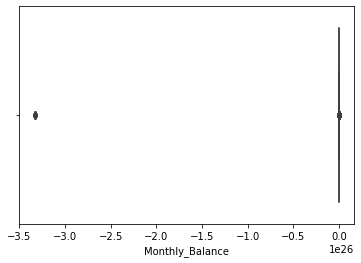

In [17]:
sns.boxplot(x=final_dataset['Monthly_Balance'])

In [18]:
# Calculate the median delayed payments by customer using groupby and summarize
median_Monthly_Balance_customer = final_dataset.groupby('Customer_ID').agg(median_Monthly_Balance=('Monthly_Balance', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_Monthly_Balance_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Monthly_Balance'].fillna(final_dataset['median_Monthly_Balance'], inplace=True)

# Drop the median delayed payments column
final_dataset.drop('median_Monthly_Balance', axis=1, inplace=True)

In [19]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         100000 non-null  float64 
 14  Credi

Dealing with the missing value in Credit_History_Age column

In [20]:
# Define function to convert string to number of months
def convert_to_months(s):
    # If value is null or empty, return default value 0
    if pd.isna(s) or s.strip() == "":
        return 0
    # Split string into years and months
    years, months = s.split(" Years and ")
    months = months.replace(" Months", "")
    # Convert to total months
    total_months = int(years) * 12 + int(months)
    return total_months

# Apply the function to the "age" column and create a new column "age_in_months"
final_dataset["Credit_History_Age"] = final_dataset["Credit_History_Age"].apply(convert_to_months)

In [21]:
# Calculate the median credit history age by customer using groupby and summarize
median_credit_history_age_customer = final_dataset.groupby('Customer_ID').agg(median_credit_history_age=('Credit_History_Age', 'median'))

# Join the median credit history age column to the dataset
final_dataset = pd.merge(final_dataset, median_credit_history_age_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Credit History Age column with median credit history age
final_dataset['Credit_History_Age'] = final_dataset['Credit_History_Age'].apply(lambda x: final_dataset['median_credit_history_age'][x] if x == 0 else x)

# Drop the median credit history age column
final_dataset.drop('median_credit_history_age', axis=1, inplace=True)

In [22]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      100000 non-null  float64 
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         100000 non-null  float64 
 14  Credi

Dealing with Occupation column

In [23]:
final_dataset['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [24]:
# Remove rows where the "Occupation" column has the value "_______"
final_dataset = final_dataset[~(final_dataset['Occupation'] == '_______')]
final_dataset['Occupation'].value_counts()

Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

Dealing with Annual Income column

In [25]:
final_dataset['Annual_Income'].value_counts()

36585.12      16
17273.83      15
9141.63       15
17816.75      14
95596.35      14
              ..
39883.46_      1
14773.91_      1
14059195.0     1
14365.54_      1
16857.295_     1
Name: Annual_Income, Length: 18560, dtype: int64

In [26]:
# Remove rows where the "Annual_Income" column has the value "_"
final_dataset['Annual_Income'] = final_dataset['Annual_Income'].str.replace('_', '')
# Converting "Annual_Income" column to numeric
final_dataset['Annual_Income'] = pd.to_numeric(final_dataset['Annual_Income'],errors='coerce')
final_dataset['Annual_Income'].value_counts()

<ipython-input-26-3b06a30f0dc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Annual_Income'] = final_dataset['Annual_Income'].str.replace('_', '')
<ipython-input-26-3b06a30f0dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Annual_Income'] = pd.to_numeric(final_dataset['Annual_Income'],errors='coerce')


36585.12       16
40341.16       15
17816.75       15
9141.63        15
109945.32      15
               ..
8681121.00      1
12083640.00     1
20703498.00     1
3301922.00      1
11603023.00     1
Name: Annual_Income, Length: 13409, dtype: int64

Dealing with Credit Score column

In [27]:
final_dataset['Credit_Score'].value_counts()

Standard    49386
Poor        26967
Good        16585
Name: Credit_Score, dtype: int64

Dealing with Payment Behaviour column

In [28]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
!@9#%8                               7086
Name: Payment_Behaviour, dtype: int64

In [29]:
# Remove rows where the "Payment_Behaviour" column has the value "!@9#%8"
final_dataset = final_dataset[~(final_dataset['Payment_Behaviour'] == '!@9#%8')]

In [30]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
Name: Payment_Behaviour, dtype: int64

In [31]:
final_dataset["Payment_Behaviour"] = final_dataset["Payment_Behaviour"].replace({"High_spent_Large_value_payments": 6,
                                                                       "High_spent_Medium_value_payments": 5,
                                                                       "High_spent_Small_value_payments": 4,
                                                                       "Low_spent_Large_value_payments": 3,
                                                                       "Low_spent_Medium_value_payments": 2,
                                                                       "Low_spent_Small_value_payments": 1})


<ipython-input-31-12c807d84c04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset["Payment_Behaviour"] = final_dataset["Payment_Behaviour"].replace({"High_spent_Large_value_payments": 6,


In [32]:
final_dataset["Payment_Behaviour"].value_counts()

1    23720
5    16301
2    12882
6    12767
4    10524
3     9658
Name: Payment_Behaviour, dtype: int64

Dealing with Total_EMI_per_month column

In [33]:
final_dataset['Total_EMI_per_month'].value_counts()

0.000000        9051
94.787996          8
78.749713          8
27.555866          8
81.822857          8
                ... 
991.000000         1
19940.000000       1
12598.000000       1
23135.000000       1
58638.000000       1
Name: Total_EMI_per_month, Length: 14445, dtype: int64

Dealing with the Payment_of_Min_Amount column

In [34]:
final_dataset['Payment_of_Min_Amount'].value_counts()

Yes    44892
No     30635
NM     10325
Name: Payment_of_Min_Amount, dtype: int64

In [35]:
final_dataset['Payment_of_Min_Amount'] = final_dataset['Payment_of_Min_Amount'].replace({"No": 2,
                                                                       "Yes": 1,
                                                                       "NM": 0})

<ipython-input-35-735823938f1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Payment_of_Min_Amount'] = final_dataset['Payment_of_Min_Amount'].replace({"No": 2,


In [36]:
final_dataset['Payment_of_Min_Amount'].value_counts()

1    44892
2    30635
0    10325
Name: Payment_of_Min_Amount, dtype: int64

Dealing with Outstanding_Debt column

In [37]:
final_dataset['Outstanding_Debt'].value_counts()

1151.7      23
1360.45     21
460.46      20
1109.03     19
815.62      16
            ..
1190.67_     1
1644.31_     1
884.18_      1
825.25_      1
864.67_      1
Name: Outstanding_Debt, Length: 13034, dtype: int64

In [38]:
# Remove rows where the "Outstanding_Debt" column has the value "_"
final_dataset['Outstanding_Debt'] = final_dataset['Outstanding_Debt'].str.replace('_', '')
# Converting "Outstanding_Debt" column to numeric
final_dataset['Outstanding_Debt'] = pd.to_numeric(final_dataset['Outstanding_Debt'],errors='coerce')

In [39]:
final_dataset['Outstanding_Debt'].value_counts()

1151.70    24
1360.45    21
460.46     21
1109.03    20
804.31     16
           ..
884.52      2
1424.12     2
829.30      2
1661.55     1
45.65       1
Name: Outstanding_Debt, Length: 12203, dtype: int64

Dealing with Delay_from_due_date column

In [40]:
final_dataset['Delay_from_due_date'].value_counts()

 15    3096
 13    2903
 14    2846
 8     2839
 10    2801
       ... 
-4       52
 65      47
 66      28
-5       27
 67      19
Name: Delay_from_due_date, Length: 73, dtype: int64

In [41]:
final_dataset.loc[final_dataset['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = 0

In [42]:
final_dataset['Delay_from_due_date'].value_counts()

15    3096
13    2903
14    2846
8     2839
10    2801
      ... 
63      58
64      53
65      47
66      28
67      19
Name: Delay_from_due_date, Length: 68, dtype: int64

Dealing with the Num_of_Loan column

In [43]:
final_dataset['Num_of_Loan'].value_counts()

3        12340
2        12302
4        12049
0         8842
1         8681
         ...  
252          1
745          1
1320_        1
103          1
966          1
Name: Num_of_Loan, Length: 378, dtype: int64

In [44]:
# Remove rows where the "Num_of_Loan" column has the value "_"
final_dataset['Num_of_Loan'] = final_dataset['Num_of_Loan'].str.replace('_', '')
# Converting "Num_of_Loan" column to numeric
final_dataset['Num_of_Loan'] = pd.to_numeric(final_dataset['Num_of_Loan'],errors='coerce')

In [45]:
final_dataset.loc[final_dataset['Num_of_Loan'] == "-100", 'Num_of_Loan'] = np.nan

In [46]:
# Calculate the median Num_of_Loan by customer using groupby and summarize
median_Num_of_Loan_customer = final_dataset.groupby('Customer_ID').agg(median_Num_of_Loan=('Num_of_Loan', 'median'))

# Join the median Num_of_Loan column to the dataset
final_dataset = pd.merge(final_dataset, median_Num_of_Loan_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Num_of_Loan column with median credit history age
final_dataset['Num_of_Loan'].fillna(final_dataset['median_Num_of_Loan'], inplace=True)

# Drop the median Num_of_Loan column
final_dataset.drop('median_Num_of_Loan', axis=1, inplace=True)

In [47]:
final_dataset['Num_of_Loan'].value_counts()

2.0       12974
3.0       12964
4.0       12660
0.0        9322
1.0        9126
          ...  
952.0         1
661.0         1
321.0         1
1439.0        1
966.0         1
Name: Num_of_Loan, Length: 361, dtype: int64

In [48]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85852 entries, 0 to 85851
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      85852 non-null  object  
 1   Customer_ID             85852 non-null  category
 2   Occupation              85852 non-null  object  
 3   Annual_Income           85852 non-null  float64 
 4   Monthly_Inhand_Salary   85852 non-null  float64 
 5   Num_of_Loan             85852 non-null  float64 
 6   Delay_from_due_date     85852 non-null  int64   
 7   Num_of_Delayed_Payment  85852 non-null  float64 
 8   Outstanding_Debt        85852 non-null  float64 
 9   Credit_History_Age      85852 non-null  float64 
 10  Payment_of_Min_Amount   85852 non-null  int64   
 11  Total_EMI_per_month     85852 non-null  float64 
 12  Payment_Behaviour       85852 non-null  int64   
 13  Monthly_Balance         85852 non-null  float64 
 14  Credit_Score          

Lets work on the outliers in different columns like "Num_of_Delayed_Payment", "Total_EMI_per_month", "Num_of_Loan" and "Annual_Income"

In [49]:
#sorted(final_dataset['Num_of_Delayed_Payment'])

In [50]:
#quantile1, quantile3 = np.percentile(final_dataset['Num_of_Delayed_Payment'],[25,75])

In [51]:
#print(quantile1,quantile3)

In [52]:
#iqr_value = quantile3 - quantile1
#print(iqr_value)

In [53]:
#lowerbound = quantile1 - (1.5 * iqr_value)
#upperbound = quantile3 + (1.5 * iqr_value)
#print(lowerbound,upperbound)